# Ngưỡng cắt thông số lâm sàng: Cách làm sai và đúng

### BS. Lê Ngọc Khả Nhi

# Đặt vấn đề

Trong một bài báo gần đây trên tờ Human Reproduction : https://sci-hub.do/10.1093/humrep/deaa322; nhóm tác giả người Tây Ban Nha muốn xác định ngưỡng cắt của nồng độ progesterone huyết thanh vào ngày chuyển phôi (ET), mà giá trị thấp hơn ngưỡng này có liên hệ với nguy cơ diễn tiến thai kì thất bại. Họ có một bộ dữ liệu khá lớn lên tới 1150 cases. Tuy nhiên, họ đã giải quyết bài toán theo một cách rất kì quái như sau:

Đầu tiên, họ chia thang đo của nồng độ progesterone thành 10 phần bằng nhau để tạo ra 10 ngưỡng cắt tiềm năng (thập phân vị 1-10), tiếp theo họ so sánh tỉ lệ thai kì diễn tiến thành công cho mỗi phân nhóm rồi dựa vào đó để xác định một ngưỡng cắt = 8.8 ng/mL. Sau đó, họ dùng ROC analysis để đánh giá hiệu năng của ngưỡng cắt 8.8 đó.

Trong bài thực hành này, Nhi sẽ làm thí nghiệm để mô phỏng lại bài toán này, để chứng minh cách làm của nhóm tác giả trên là hoàn toàn sai lầm; đồng thời Nhi sẽ hướng dẫn các bạn về cách làm đúng.

# Tạo dữ liệu mô phỏng

Trước hết, Nhi tạo ra 1 dữ liệu mô phỏng một bài toán nhị phân với đúng bằng 1150 cases, gồm X là 1 biến liên tục có phân bố Gaussian với thang đo từ 0 đến 25, và Y là biến nhị phân với tỉ lệ giá trị 0/1 lần lượt là 28% và 72%, kích thước nhiễu là 5%.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import itertools
from imblearn.over_sampling import SMOTE

from scipy import interp

%config InlineBackend.figure_format = 'svg'

from sklearn.datasets import make_classification

import scipy.stats as stats

In [2]:
X, y =  make_classification(n_samples=1150,
                            n_features=2,
                            n_informative=2, 
                            n_redundant=0,
                            weights = [0.28,0.72],
                            n_classes=2,
                            scale = 3.5,
                            flip_y=0.05,
                            shuffle=True, 
                            random_state=123)

df = pd.DataFrame({'X': X[:,1], 'Class':y})
df['X'] = df['X'] - df['X'].min() + 1

df

,X,Class
0,8.651363,0
1,14.930796,1
2,8.958934,0
3,14.086558,1
4,15.931177,1
...,...,...
1145,12.052086,1
1146,8.014364,0
1147,9.796510,0
1148,9.342547,0


# Tái hiện cách làm sai của nhóm tác giả

Có thể nhận ra các tác giả chịu ảnh hưởng sâu sắc bởi cách suy nghĩ 'định tính hóa', một lối làm việc tùy tiện nhưng khá phổ biến trong ngành Y khoa. Các bác sĩ có khuynh hướng cắt thang đo định lượng thành nhiều phần rồi dùng chúng như biến định tính rời rạc, thay vì khảo sát trực tiếp biến định lượng.

Nhi tái hiện lại cách mà họ đã cắt thang đo X thành thập phân vị:

In [3]:
df['X_dec'] = pd.qcut(df['X'],q=10)

for i in enumerate(df['X_dec'].unique().categories.sortlevel()[0].values):
    print(f"Thập phân vị thứ {i[0]+1} : {i[1]}")

Thập phân vị thứ 1 : (0.999, 8.109]
Thập phân vị thứ 2 : (8.109, 10.111]
Thập phân vị thứ 3 : (10.111, 12.164]
Thập phân vị thứ 4 : (12.164, 13.755]
Thập phân vị thứ 5 : (13.755, 14.729]
Thập phân vị thứ 6 : (14.729, 15.566]
Thập phân vị thứ 7 : (15.566, 16.472]
Thập phân vị thứ 8 : (16.472, 17.347]
Thập phân vị thứ 9 : (17.347, 18.687]
Thập phân vị thứ 10 : (18.687, 24.271]


Lúc này, ta đã biến X từ 1 biến định lượng liên tục thành 1 biến định tính rời rạc với 10 bậc giá trị. 

Ở đây, ta lưu ý 1 điều đó là giá trị biến định tính nhị phân thường được khảo sát/mô tả dưới 2 hình thức : tần suất hoặc tỉ lệ. Trong lập trình thống kê, 2 hình thức này tương đương với hàm sum() và hàm mean() cho 1 biến boolean (nhị phân), thực vậy, hàm sum() các giá trị = 1 cho ra tần suất, hàm mean() các giá trị = 1 cho ra tỉ lệ:

Tiếp theo, như các tác giả đã làm, Nhi cũng thống kê tần suất và tỉ lệ giá trị = 1 của biến kết quả Class cho mỗi phân nhóm thập phân vị:

In [4]:
df.groupby('X_dec')[['Class']].agg(['sum','mean'])

Class          
                   sum      mean
X_dec                           
(0.999, 8.109]       4  0.034783
(8.109, 10.111]     19  0.165217
(10.111, 12.164]    45  0.391304
(12.164, 13.755]    92  0.800000
(13.755, 14.729]   108  0.939130
(14.729, 15.566]   111  0.965217
(15.566, 16.472]   108  0.939130
(16.472, 17.347]   109  0.947826
(17.347, 18.687]   114  0.991304
(18.687, 24.271]   110  0.956522

Tuy nhiên trong bài báo, tác giả còn ước tính cả khoảng tin cậy của tỉ lệ thụ thai thành công cho mỗi phân nhóm nữa, họ đã làm điều đó như thế nào ? Câu trả lời đó là bootstrap !

Nhi viết 1 hàm cho phép thực hiện bootstrap 1000 lượt cho tỉ lệ Class=1, từ đó xuất ra bách phân vị thứ 5 và 95 của tất cả giá trị này.

In [5]:
def boot_rate(x = None, n_iter = 1000):
    rates = np.zeros(n_iter)
    i = 0
    while i<n_iter:
        rates[i] = x.sample(100, replace=True).mean()
        i+=1
    ci = np.quantile(rates, q = [0.05,0.95])
    return [ci[0],ci[1]]

Áp dụng hàm này kết hợp với hàm mean(), Nhi có thể tạo ra kết quả tương tự như trong bài báo như sau:

In [6]:
dec_df = df.groupby('X_dec')[['Class']].agg([np.mean,boot_rate])
dec_df.columns = ['Mean','CI95']
dec_df['LB'] = [v[0] for v in dec_df['CI95']]
dec_df['UB'] = [v[1] for v in dec_df['CI95']]
dec_df['Dec'] = [str(i) for i in dec_df.index]

dec_df[['Mean','LB','UB','Dec']]

,Mean,LB,UB,Dec
X_dec,,,,
"(0.999, 8.109]",0.034783,0.0100,0.0605,"(0.999, 8.109]"
"(8.109, 10.111]",0.165217,0.1100,0.2300,"(8.109, 10.111]"
"(10.111, 12.164]",0.391304,0.3100,0.4700,"(10.111, 12.164]"
"(12.164, 13.755]",0.800000,0.7400,0.8600,"(12.164, 13.755]"
"(13.755, 14.729]",0.939130,0.8995,0.9800,"(13.755, 14.729]"
"(14.729, 15.566]",0.965217,0.9300,0.9900,"(14.729, 15.566]"
"(15.566, 16.472]",0.939130,0.8995,0.9800,"(15.566, 16.472]"
"(16.472, 17.347]",0.947826,0.9100,0.9800,"(16.472, 17.347]"
"(17.347, 18.687]",0.991304,0.9700,1.0000,"(17.347, 18.687]"


Bây giờ chỉ còn việc vẽ hình: Ta có thể tạo ra 1 biểu đồ tương tự trong bài báo như sau:

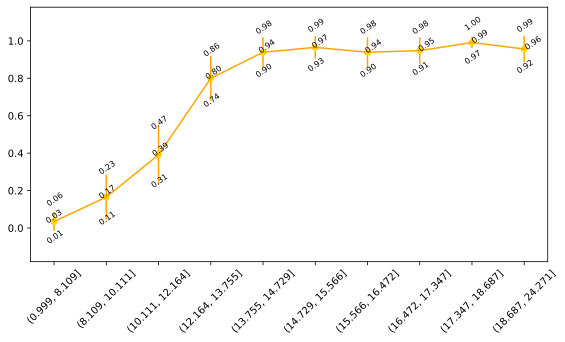

In [7]:
plt.figure(figsize=(8,5))
plt.errorbar(x = dec_df['Dec'],
             y = dec_df['Mean'], 
             yerr = dec_df['UB'] - dec_df['LB'],
             color = 'orange')
plt.plot(dec_df['Dec'], dec_df['Mean'],'o',color ='gold')
plt.xticks(rotation = 45)

for x,m,l,u in zip(dec_df['Dec'], dec_df['Mean'], dec_df['LB'], dec_df['UB']):
    
    m_label = "{:.2f}".format(m)
    l_label = "{:.2f}".format(l)
    u_label = "{:.2f}".format(u)
    
    plt.annotate(m_label,
                 (x,m-0.01),
                 textcoords="offset points",
                 rotation = 35,
                 fontsize = 8,
                 ha='center')
    
    plt.annotate(l_label,
                 (x,l-0.1),
                 textcoords="offset points",
                 xytext=(1,1),
                 rotation = 35,
                 fontsize = 8,
                 ha='center')
    
    plt.annotate(u_label,
                 (x,u+0.05),
                 textcoords="offset points",
                 xytext=(1,1),
                 rotation = 35,
                 fontsize = 8,
                 ha='center')

plt.tight_layout()
plt.ylim(-0.18,1.18)
plt.show()

Trong bài báo, tác giả đã dựa vào hình ảnh giống như thế này, để xác định 1 ngưỡng cắt tương ứng với ngưỡng dưới của thập phân vị thứ 3. Trong bài toán minh họa này, nếu làm như vậy ta có thể nói ngưỡng cắt tiềm năng chính là 10.11; vì có sự tương phản rõ nhất giữa thập phân vị 3 và 4.

Tuy nhiên ta sẽ tự hỏi: cái quái gì thế này ? Tại sao họ lại tự giảm độ phân giải từ thang đo liên tục thành ra 1 thang đo chỉ có 10 bậc ?

Sau đây, chúng ta sẽ giải quyết theo cách làm đúng, đó là tối ưu hóa ngưỡng cắt bằng ROC analysis

# Cách làm đúng: tối ưu hóa ngưỡng cắt bằng ROC analysis

## Thăm dò dữ liệu

Thay vì làm cầu kì phức tạp như tác giả, ta chỉ cần khảo sát trực tiếp mỗi biến số trong bài toán theo đúng bản chất tự nhiên của nó: Class là 1 biến nhị phân, X là 1 biến liên tục:

Chỉ bằng biểu đồ KDE plot, ta có thể ước đoán gần chính xác ngưỡng cắt tối ưu của X cho phép phân định Y thành 2 nhóm:

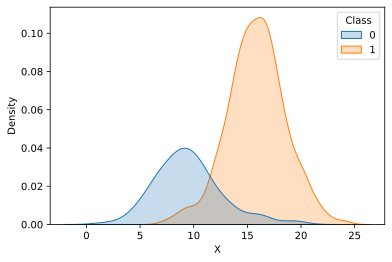

In [8]:
plt.figure(figsize=(6,4))
sns.kdeplot(x = df.X, hue = df['Class'], shade = 'True')
plt.show()

Ta lại nhận ra: Biểu đồ lineplot và errorbar mà tác giả đã dùng, nó có gần giống như 2 đồ thị hàm CDF của phân phối Binomial và Bernoulli hay không ?

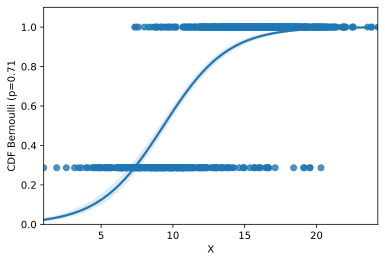

In [9]:
plt.figure(figsize=(6,4))

sns.regplot(x = df['X'], 
            y = stats.bernoulli.cdf(df['Class'], p=df['Class'].mean()),
           logistic = True)

plt.ylim([0,1.1])
plt.ylabel(f"CDF Bernoulli (p={df['Class'].mean():.2f}")
plt.show()

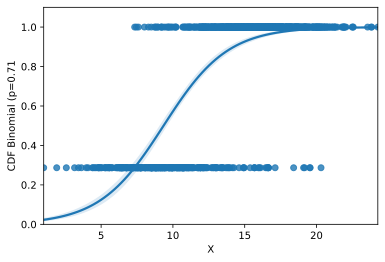

In [10]:
plt.figure(figsize=(6,4))

sns.regplot(x = df['X'], 
            y = stats.binom.cdf(df['Class'], p=df['Class'].mean(), n = 1), 
            logistic = True)

plt.ylabel(f"CDF Binomial (p={df['Class'].mean():.2f}")

plt.ylim([0,1.1])
plt.show()

Hay đồ thị của hàm logistic, tương ứng mô hình Class ~ X: 

<AxesSubplot:xlabel='X', ylabel='Class'>

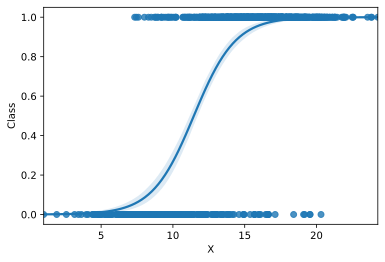

In [11]:
plt.figure(figsize=(6,4))

sns.regplot(data = df, x = 'X', y = 'Class', logistic=True)

Trước hết, Nhi chuẩn bị code cho 1 phân tích ROC, với class ROC_analysis và 2 hàm rời cho phép vẽ ROC curve

In [36]:
class ROC_analysis:
    
    def __init__(self, X, Y):
        
        sm = SMOTE()
        X,Y = sm.fit_resample(df['X'].values.reshape(-1,1),df['Class'])
        self.X, self.Y = pd.Series(X.flatten()),Y
    
    def binary_rule(self, thres = None):
        score = pd.Series(self.X)
        lab_rule = {thres:1,float('-inf'):0}
    
        def lab_mapping(value):
            for k, lab in lab_rule.items():
                if value >= k:
                    return lab

        pred = score.map(lab_mapping)

        return score, pred.values
    
    def cutoff_analysis(self, resolution = 1000, xmin=0, xmax=100, crit = 'F1'):
        
        thres_list = np.linspace(xmin, xmax, resolution)
        temp_perf = np.zeros(10)
        
        for t in thres_list:
        
            score, pred = self.binary_rule(thres = t)

            cnf_matrix = confusion_matrix(self.Y,pred)

            TN, FP, FN, TP = cnf_matrix.ravel()
            TPR=TP/(TP+FN)
            TNR=TN/(TN+FP)
            SEN=TPR
            SPEC=TNR
            Recall=SEN
            ACC=(TP+TN)/(TP+FP+TN+FN)
            PPV=TP/(TP+FP)
            NPV=TN/(TN+FN)
            LRpos=SEN/(1-SPEC)
            LRneg=(1-SEN)/SPEC
            J = SEN + SPEC - 1

            f1 = f1_score(self.Y, pred)
            bac = balanced_accuracy_score(self.Y, pred)
            
            temp_perf = np.vstack([temp_perf, [t, SEN, SPEC, f1, bac, PPV, NPV, LRpos, LRneg, J]])
        
        perf_df = pd.DataFrame(temp_perf).iloc[1:]
        perf_df.columns = ['Thres', 'Sen', 'Spec', 'F1', 'BAC', 'PPV', 'NPV', 'LRp', 'LRn', 'Youden_J']
        best_cut = perf_df[perf_df[crit] == perf_df[crit].max()]
        
        print(f'Xác định ngưỡng cắt tối ưu theo tiêu chí {crit}')
        
        self.best_cut = best_cut
        self.perf_df = perf_df
                    
        plt.rcParams.update({'font.size': 10})
        plt.figure(figsize=(10,5))
        plt.plot(thres_list[:-1], self.perf_df['Spec'][:-1], label="Độ đặc hiệu", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Sen'][:-1], label="Độ nhạy", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['F1'][:-1], label="Điểm F1", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['BAC'][:-1], label="Độ chính xác", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Youden_J'][:-1], label="Youden'J", linewidth=2)
        
        bc = self.best_cut['Thres'].values[0]
        plt.vlines(x = bc, 
                   ymin = 0.1, 
                   ymax = 1, 
                   colors = 'k', 
                   linestyles='dashed',
                  label = f'Ngưỡng tối ưu:{bc:.2f}')

        plt.xlabel("Thang đo", fontsize=15)
        plt.ylabel("Điểm số", fontsize=15)
        plt.legend(fontsize=12)
        plt.ylim([0.1, 1])
        plt.xlim([xmin, xmax])
        
        return best_cut

    def Boot_ROCcurve(self,n_iter = 1000):
                    
        score, pred = self.binary_rule(thres = self.best_cut['Thres'].values[0])
        tprs = []
        aucs = []
        base_fpr = np.linspace(0, 1, 101)

        valid_df = pd.DataFrame({'Truth': self.Y,
                                 'Pred': pred,
                                 'Score': score},
                                index = self.Y.index)

        for i in range(n_iter):
            resamp_df = valid_df.sample(1000, replace=True)

            if len(np.unique(resamp_df['Pred'])) < 2:
                continue

            fpr, tpr, _ = roc_curve(resamp_df['Truth'], resamp_df['Score'])

            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        mean_auc = auc(base_fpr, mean_tprs)
        std_auc = np.std(aucs)

        tprs_up = np.minimum(mean_tprs + 1.645*std, 1)
        tprs_low = mean_tprs - 1.645*std

        plt.rcParams["figure.figsize"] = (7,6.6)
        plt.rcParams.update({'font.size': 12})

        plt.plot(base_fpr, mean_tprs, 'r', 
                 alpha = 1, 
                 label=r'AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),)

        plt.fill_between(base_fpr, 
                         tprs_low, tprs_up, 
                         color = 'red', alpha = 0.3)

        plt.plot([0, 1], [0, 1], 
                 linestyle = '--', 
                 lw = 2, 
                 color = 'grey', 
                 label = 'Đoán ngẫu nhiên', 
                 alpha= 0.5)
        
        plt.vlines(x = 1 - self.best_cut['Spec'], 
                   ymin = 0., 
                   ymax = 1, 
                   colors = 'k', 
                   linewidth = .8,
                   linestyles='dashed',)
        
        plt.hlines(y = self.best_cut['Sen'], 
                   xmin = 0., 
                   xmax = 1, 
                   colors = 'k',
                   linewidth = 0.8,
                   linestyles='dashed',)
        
        plt.plot(1 - self.best_cut['Spec'],
                 self.best_cut['Sen'], 
                 'ko')

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])

        plt.ylabel('Tỉ lệ dương tính thật')
        plt.xlabel('Tỉ lệ dương tính giả')
        plt.legend(loc="lower right")
        plt.title('Đường cong ROC')
        
def binary_rule(score: pd.Series, thres = None):
    lab_rule = {thres:1,float('-inf'):0}
    
    def lab_mapping(value):
        for k, lab in lab_rule.items():
            if value >= k:
                return lab

    pred = score.map(lab_mapping)

    return pred.values

def ext_validation(X: pd.Series,
                  y: pd.Series,
                  roc_calib: ROC_analysis,
                  n_iter: int):
    
    cut_off = roc_calib.best_cut.iloc[0]['Thres']
    
    valid_df = pd.DataFrame({'Truth': y,
                             'Pred': binary_rule(score = X, thres = cut_off),
                             'Score': X}, 
                            index = X.index)
    
    TPR_lst = []
    TNR_lst = []
    NPV_lst = []
    Recall_lst = []
    PPV_lst = []
    F1_lst = []
    BAC_lst = []
    
    for i in range(n_iter):
        resamp_df = valid_df.sample(valid_df.shape[0], replace=True)
        
        if len(np.unique(resamp_df['Pred'])) < 2:
            continue
        
        cnf_matrix = confusion_matrix(resamp_df['Truth'], 
                                      resamp_df['Pred'])
        
        TN, FP, FN, TP = cnf_matrix.ravel()
        TPR=TP/(TP+FN)
        TNR=TN/(TN+FP)
        SEN=TPR
        SPEC=TNR
        Recall=SEN
        ACC=(TP+TN)/(TP+FP+TN+FN)
        BAC=(TPR+TNR)/2
        PPV=TP/(TP+FP)
        NPV=TN/(TN+FN)
        Precision=PPV
        
        F1 = f1_score(resamp_df['Truth'], 
                      resamp_df['Pred'],
                      average = 'weighted')
                
        Recall_lst.append(Recall)
        PPV_lst.append(Precision)
        F1_lst.append(F1)
        BAC_lst.append(BAC)
        TPR_lst.append(TPR)
        TNR_lst.append(TNR)
        NPV_lst.append(NPV)
    
    Boot_df = pd.DataFrame({'Recall':Recall_lst,
                            'PPV': PPV_lst,
                            'F1':F1_lst,
                            'BAC': BAC_lst,
                            'TPR': TPR_lst,
                            'TNR': TNR_lst,
                            'NPV': NPV_lst,
                           })
    
    return Boot_df

## Xác định ngưỡng cắt bằng ROC analysis

Tiếp theo, Nhi sẽ chia ngẫu nhiên dữ liệu thành 2 phần train và test, với tỉ lệ 50%; như vậy ta có 1 dữ liệu dùng để xác định ngưỡng cắt tối ưu, và 1 dữ liệu độc lập để kiểm nghiệm hiệu năng của ngưỡng này.

Áp dụng method cutoff_analysis của class ROC_analysis cho tập train, ta xác định được ngưỡng cắt tối ưu là 12.37

Xác định ngưỡng cắt tối ưu theo tiêu chí BAC


,Thres,Sen,Spec,F1,BAC,PPV,NPV,LRp,LRn,Youden_J
437,12.367979,0.904878,0.865854,0.88756,0.885366,0.870892,0.901015,6.745455,0.109859,0.770732
438,12.389122,0.904878,0.865854,0.88756,0.885366,0.870892,0.901015,6.745455,0.109859,0.770732


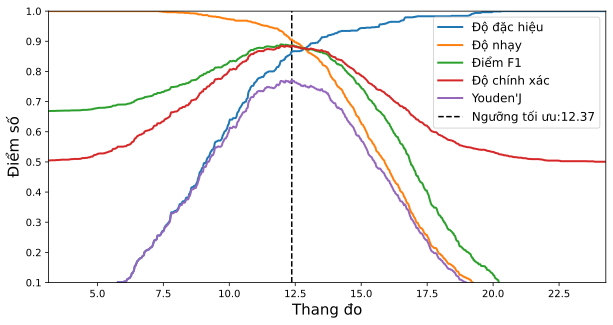

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['Class'], test_size=0.5, random_state=555)

r = ROC_analysis(X_train, y_train)

r.cutoff_analysis(resolution = 1000, 
                  xmin = X_train.min(), 
                  xmax = X_train.max(), 
                  crit = 'BAC')

Tập dữ liệu train tương ứng với 1 đường cong ROC có AUC = 0.93 như sau:

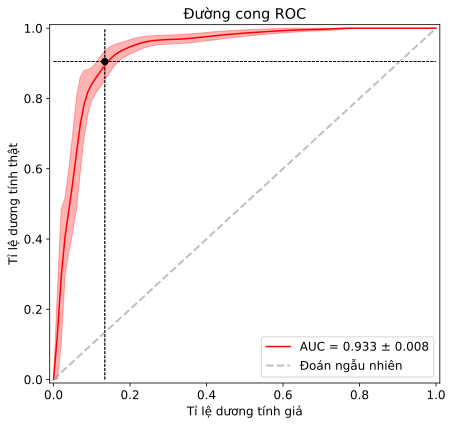

In [15]:
r.Boot_ROCcurve()

Vị trí của ngưỡng cắt trên thang đo của X như sau:

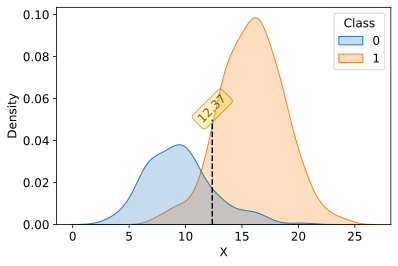

In [16]:
plt.figure(figsize=(6,4))
sns.kdeplot(x = X_train, hue = y_train, shade = 'True')
plt.vlines(x = r.best_cut.iloc[0]['Thres'],
          ymin = 0., 
          ymax = 0.05, 
          colors = 'k', 
          linestyles='dashed',)

plt.text(x = r.best_cut.iloc[0]['Thres'],
         y = 0.055,
         s = f"{r.best_cut.iloc[0]['Thres']:.2f}",
         alpha = 0.6,
         rotation=45,
         ha="center", 
         va="center",
         bbox=dict(boxstyle="round",alpha = 0.3,fc='gold',)
        )

plt.show()

## Kiểm định độc lập

Để khẳng định hiệu năng của ngưỡng cắt mà ta chọn, Nhi sử dụng phần còn lại của dữ liệu (tập X_test, y_test). 

Nhi sẽ thực hiện 1 phân tích bootstrap với hàm boot_valid, tính 7 performance metrics qua 1000 lượt tái chọn mẫu, sau đó khảo sát phân bố của chúng.

In [37]:
boot_valid = ext_validation(X = X_test,
                            y = y_test, 
                            roc_calib = r,
                            n_iter = 1000)

Kết quả cho thấy với ngưỡng cắt tối ưu đã chọn, hầu hết các tiêu chí đều có giá trị trung vị cao, thí dụ F1  = 0.92, BAC = 0.91...

In [48]:
boot_valid.describe(percentiles = [0.025,0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
Recall,1000.0,0.910981,0.013889,0.863208,0.882353,0.911695,0.937053,0.953704
PPV,1000.0,0.937181,0.011851,0.896985,0.913041,0.936938,0.959678,0.974490
F1,1000.0,0.895266,0.012339,0.853728,0.869601,0.895608,0.919659,0.935874
BAC,1000.0,0.882703,0.014924,0.832661,0.851590,0.882630,0.910823,0.931415
TPR,1000.0,0.910981,0.013889,0.863208,0.882353,0.911695,0.937053,0.953704
TNR,1000.0,0.854424,0.026359,0.762821,0.798851,0.854545,0.905562,0.935897
NPV,1000.0,0.801019,0.029835,0.686486,0.738220,0.803150,0.854181,0.888268


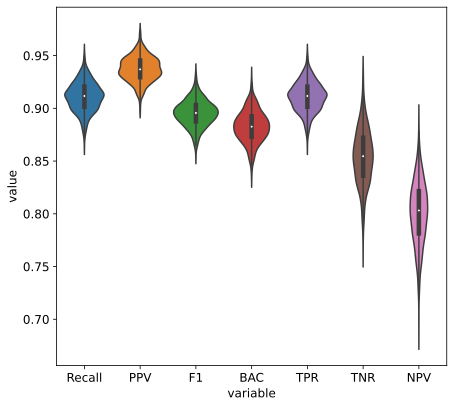

In [50]:
sns.violinplot(x="variable", y="value", data=pd.melt(boot_valid))
plt.show()

Đây mới thực sự là ngưỡng cắt tối ưu ta cần tìm. Qua thí nghiệm này, ta có thể rút ra kinh nghiệm: Định tính hóa thang đo liên tục là một điều sai lầm, và mọi giải pháp dựa trên kỹ thuật này đều kém chính xác. Các bạn bác sĩ không nên tiếp tục dùng cách làm này. Giải pháp tốt nhất đó là khảo sát mỗi biến trong bài toán một cách trực tiếp và đúng như bản chất của chúng.

Hẹn gặp lại các bạn lần sau.